# Background

Our universe was born in a fiery explosion. Today it is a cold network of dark matter. Much of the transition process between these endpoints is well understood, but the connection between dark matter and galaxy formation is one area that is still wanting. The force behind the condensation of mass on large scales into galaxies is gravition. This typically feeble force, becomes is leveraged by extremely large pools of dark matter, called dark matter halos, into a powerful large scale force that condenses structures in the universe and fuels galaxy formation. In the past decade N-body simulations have provided reliable large scale structure data under various cosmology scenarios. In parallel, large surveys have provided large galaxy datasets. The ultimate goal of our research is to better understand galaxy formation by connecting the dark matter structure from simulations to galaxy luminosities from surveys.

We will be attempting to infer the mass luminosity over a large field of view, which is motivated by our eventual desire to incorporate weak lensing information. We have taken a mass luminosity relation from [1] and have created a realistic dataset to validate our inference and resulting posteriors with. For our Physics 366 project we propose exploring this computationally challenging inference through the lens of optimization. Optimization offers the dual benefits of computational efficiency and a faster route to answering certain questions.

# Model

Our model consists of N independent halos that each have a redshift, mass, luminosity, and observed luminosity. Two functional hyperparameters and one observational noise hyperparameter govern the relation between these halo features. The conditional probability relationship between these parameters is captured in the probabilistic graphical model below.

#### PGM

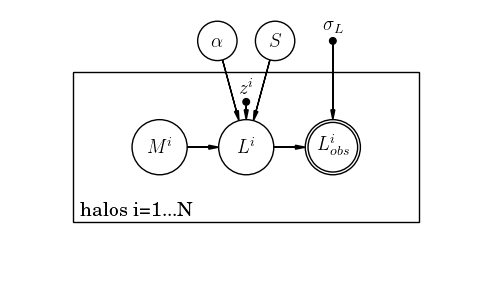

In [3]:
from IPython.display import Image
Image(filename='pgm.png') 

#### Variables

- $\alpha$: a set of functional parameters that converts mass into mean luminosity. (See below)
- $S$: the scatter of the lognormal distribution that converts mean luminosity to intrinsic luminosity. (See below)
- $\sigma_L$: the lognormal scatter between luminosity and observed luminosities.
- $z^i$: redshift of the ith halo.
- $M^i$: mass of the ith halo ($M_{\odot}$).
- $L^i$: luminosity of the ith halo ($L_{\odot} / h^2$).
- $L^i_{obs}$: observed luminosity of the ith halo ($L_{\odot} / h^2$).

#### Distributions

For the mass prior we use the Tinker (2010) form and use the hmfCalc package to produce this information [2]. 

$$P(M^i) \sim \text{hmfCalc}$$

The redshift prior is fixed from the data. The $\sigma_L$ is fixed at 0.05 which is around the 1% noise level that is a common threshold in astronomy. 

$$P(z^i) \sim \text{Data}$$
$$P(\sigma_L) = \delta(\sigma_L - 0.05)$$

The $\alpha$ and $S$ hyperparameter priors are the gaussian distributions suggested by [1].

\begin{align*}
\alpha_1 &= \text{normal}(10.709,\ 0.022)\\
\alpha_2 &= \text{normal}(0.359,\ 0.009)\\
\alpha_3 &= \text{delta}(2.35 \times 10^{14})\\
\alpha_4 &= \text{normal}(1.10,\ 0.06)\\
S &= \text{normal}(0.155,\ 0.0009)\\
\end{align*}

The conditional intrinsic luminosity has two parts: the mean of the lognormal, and the scatter of the lognormal. This form again comes from [1].

$$\mu_{L^i} = \exp(\alpha_1)\left( \frac{M^i}{\alpha_3} \right)^{\alpha_2} (1+z^i)^{\alpha_3}$$
$$P(L^i|\alpha, S, z^i, M^i) = \text{lognormal}(\mu_{L^i}, S)$$

Finally we have the conditional observed luminosity:

$$P(L_{obs}^i|L^i, \sigma_L) = \text{lognormal}(L^i, \sigma_L)$$

#### Data

Our dataset is generated from a $40 \times 40\ \text{arcmin}^2$ patch of the Millennium Simulation [3]. The four fields right-ascension, declination, redshift, and halo mass come straight from this data. On top of this we generate a random set of $\alpha, S$ from our prior in order to append an intrinsic and observed luminosity for each halo. We use this dataset to confirm that the posterior of our inference is close to the true hyperparameter values used to create the dataset.

The hyperparameters that were drawn are shown below. The dataset is in the accompanying 'data.csv' file.

- $S$: 0.15513828001473409,
- $\alpha_1$: 10.706690446577582,
- $\alpha_2$: 0.37130673484214138,
- $\alpha_3$: 235000000000000.0,
- $\alpha_4$: 1.0006793577014195,

In [5]:
import pandas as pd

data = pd.read_csv('data.csv')
data.head()

,Unnamed: 0,gal_id,z,ra,dec,lum,lum_obs,mass
0,0,22005657000031,2.07709,-108.623172,-101.696113,13777.036439,13748.793557,1.005246e+11
1,1,23003396000121,2.00452,-106.131150,-104.863309,8553.898485,8259.738500,9.989612e+10
2,2,23003339006170,1.99264,-105.764686,-102.987674,18963.368661,18382.304954,3.945599e+11
3,3,23003385000769,1.99573,-105.287527,-101.737709,11060.429382,11510.690346,1.432479e+11
4,4,22000106000031,2.04182,-105.776374,-102.895886,11085.593094,12059.614847,1.344521e+11


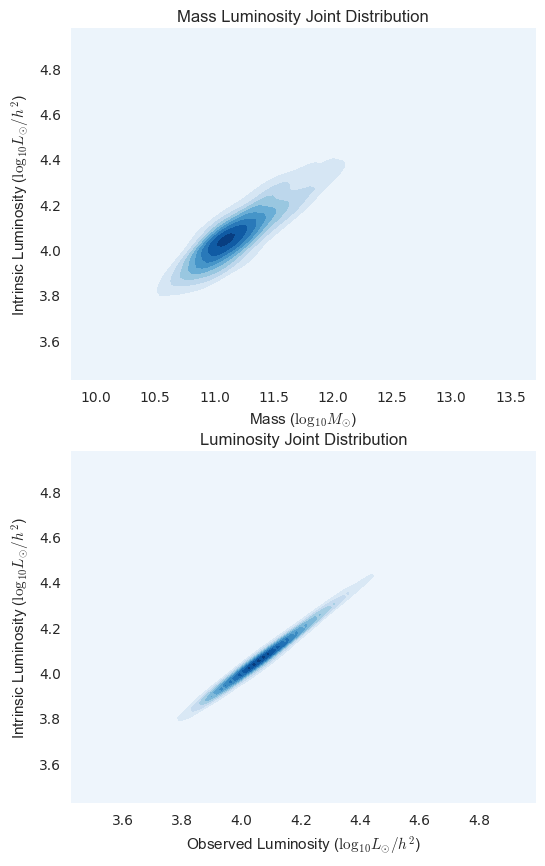

In [16]:
%matplotlib inline 

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def log10(arr):
    return np.log(arr) / np.log(10)


samples = 1000

plt.rcParams['figure.figsize'] = (6, 10)

plt.subplot(211)
plt.title('Mass Luminosity Joint Distribution')
sns.kdeplot(log10(data['mass'][:samples]), log10(data['lum'][:samples]), shade=True, cmap='Blues')
plt.xlabel('Mass ($\log_{10} M_{\odot}$)')
plt.ylabel('Intrinsic Luminosity ($\log_{10} L_{\odot} / h^2$)');

plt.subplot(212)
plt.title('Luminosity Joint Distribution')
sns.kdeplot(log10(data['lum_obs'][:samples]), log10(data['lum'][:samples]), shade=True, cmap='Blues')
plt.xlabel('Observed Luminosity ($\log_{10} L_{\odot} / h^2$)')
plt.ylabel('Intrinsic Luminosity ($\log_{10} L_{\odot} / h^2$)');

# Inference

Inference problems have a canonical form; the posterior is the product of a prior and likelihood. In our case we have 

\begin{align*}
\underbrace{P(\alpha, S | L_{obs}, z, \sigma_L)}_{posterior} \propto
&\underbrace{P(\alpha, S)}_{prior}\underbrace{\iint P(L_{obs}| L, \sigma_L)P(L|\alpha, S,z,M)P(M)dMdL}_{likelihood}
\end{align*}

where $L_{obs},\ L,\ M, \text{ and } z$ are vectorized (eg. $z = (z_1, \dots, z_N)^T$). It is worth noting that our dataset includes over 100,000 halos and hence the likelihood integral is an integral over over 200,000 variables. In this work we will explore how we can approximate the likelihood and posterior with optimization methods.

It is also worth noting that in most cases we will be using the log-likelihood, which can be reduced to

$$\log(\mathcal{L}) = \sum_{i} \iint \left(\log(P(L_{obs}^i| L^i, \sigma_L)) + \log(P(L^i|\alpha, S,z^i,M^i)) + \log(P(M^i)) \right)dM^idL^i$$

# Research

There are three separate questions we will explore:

- 1) Can we approximate each $(M^i,L^i)$ integral in the likelihood as a 2D Normal or Lognormal distribution after sparse sampling? This would involve sampling, fitting a distribution to samples via regression, and computing the integral analytically. How fast is this? How accurate is this? Can it be scaled to more than 2 dimensions.
- 2) Can we find the most likely marginal $(M^i,L^i)$ samples using variants of stochastic gradient descent?
- 3) Can we derive the maximum likelihood hyperparameters purely analytically?

# References
- [1] Rachel Marie Reddick. ReddiCosmology and galaxy formation using the galaxy-halo connection to probe cosmology. https://searchworks.stanford.edu/view/10531737. 2014.
- [2] Steven Murray, Chris Power, Aaron Robotham . HMFcalc: An Online Tool for Calculating Dark Matter Halo Mass Functions. https://arxiv.org/abs/1306.6721. 2013.
- [3] V. Springel, S. D. M. White, A. Jenkins, C. S. Frenk, N. Yoshida, L. Gao, J. Navarro, R. Thacker, D. Croton, J. Helly, J. A. Peacock, S. Cole, P. Thomas, H. Couchman, A. Evrard, J. Colberg, and F. Pearce. Simulations of the formation, evolution and clustering of galaxies and quasars. http://www.nature.com/nature/journal/v435/n7042/full/nature03597.html. 2005.